In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Import Pythia Dataset

In [2]:
with uproot.open("/home/lvaughan/Pythia/pythia/PU_dataset/dataset_mu60.root:pythia") as f:
    trk_pt = f["pT"].array()
    trk_eta = f["eta"].array()
    trk_phi = f["phi"].array()
    trk_label = f["label"].array()
    trk_q = f["q"].array()
with uproot.open("/home/lvaughan/Pythia/pythia/PU_dataset/dataset_mu60.root:fastjet") as f:
    jet_pt = f["jet_pt"].array()
    jet_eta = f["jet_eta"].array()
    jet_phi = f["jet_phi"].array()
    trk_ID = f["trk_ID"].array()

### Define Jet Class

In [3]:
class Jet:
    def __init__(self, jet_features, trk_features, trk_labels):
        self.jet_features = jet_features
        self.trk_features = trk_features
        self.trk_labels = trk_labels
        
    def get_label(self):
        sum_pt_hs = 0
        sum_pt_pu = 0.0000001
        for trk in range(len(self.trk_features)):
            if self.trk_labels[trk]==-1:
                sum_pt_hs+=self.trk_features[trk,0]**2
            else:
                sum_pt_pu+=self.trk_features[trk,0]**2
        return sum_pt_hs / (sum_pt_hs + sum_pt_pu)
    
    def set_label(self, label):
        self.label = np.float32(label)
        
    def convert_to_tensor(self):
        self.trk_features = torch.from_numpy(self.trk_features)
        self.jet_features = torch.from_numpy(self.jet_features)
        self.label = torch.tensor(self.label)

### Read Raw Data into Jet Class

In [4]:
num_jets = len(jet_pt)
print(num_jets)

Jets = []

for jet in range(num_jets):
    if jet%100==0:
        print("Processing: ", jet, " / ", num_jets, end="\r")
    if jet_eta[jet] > 4:
        continue
    jet_feats = np.array([jet_pt[jet],jet_eta[jet],jet_phi[jet]], dtype=np.float32)
    trk_feats = np.empty((0,4), dtype=np.float32)
    for trk in trk_ID[jet]:
        # ALTAS uses 400MeV cut
        if trk_pt[trk] < 0.4:
            continue
        # Implement eta cuts on tracks
        if trk_eta[trk] > 4:
            continue
        # Skip neutral particles
        if trk_q[trk]==0:
            continue
        trk_feats = np.vstack((trk_feats, np.array([trk_pt[trk], trk_eta[trk], trk_phi[trk], trk_label[trk]], dtype=np.float32)))
    Jets.append(Jet(jet_feats,trk_feats[:,0:3],trk_feats[:,-1]))

44634


### Plot Labels

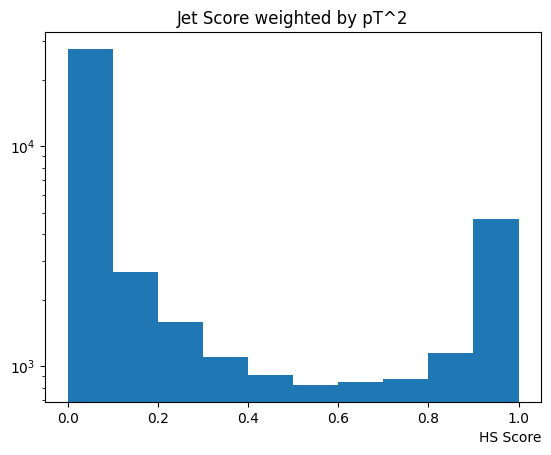

In [5]:
label = []
for jet in Jets:
    jet.set_label(jet.get_label())
    jet.convert_to_tensor()
    label.append(jet.label)
    
plt.hist(label)
plt.title("Jet Score weighted by pT^2")
plt.xlabel("HS Score",loc='right')
plt.yscale('log')

### Define Model

In [6]:
class Model(nn.Module):  
    def __init__(self):
        super(Model, self).__init__()   
        
        self.embed_dim = 64
        self.num_heads = 8
        self.num_feats = 3
        
        self.jet_initializer = nn.Linear(self.num_feats, self.embed_dim)
        self.trk_initializer = nn.Linear(self.num_feats, self.embed_dim)
        
        self.multihead_attn = nn.MultiheadAttention(self.embed_dim, self.num_heads)
        
        self.regression = nn.Linear(self.embed_dim*2, 1)
        
    def forward(self, jet_feats, trk_feats):
        trk_init = F.relu(self.trk_initializer(trk_feats))
        jet_init = F.relu(self.jet_initializer(jet_feats))
        
        query = trk_init
        key = trk_init
        value = trk_init
        
        trk_embedding, trk_weights = self.multihead_attn(query, key, value)
                
        num_trks = trk_embedding.shape[0]
        
        trk_aggregated = torch.zeros(self.embed_dim)
        for trk in range(num_trks):
            trk_aggregated = torch.add(trk_aggregated, trk_embedding[trk])
            
        jet_embedding = torch.cat((jet_init, trk_aggregated))
                
        output = F.sigmoid(self.regression(jet_embedding))
        
        return output

### Define Training Loop

In [7]:
def train(model, data, epochs=20):
    
    history = []
    
    for e in range(epochs):
        model.train()
        for entry in data:
            optimizer.zero_grad()
            output = model(entry.jet_features, entry.trk_features)
            loss=loss_fn(output, entry.label)
            loss.backward()
            optimizer.step()
        history.append(loss.detach().numpy())
        print('Epoch:',e,'\tLoss:',round(float(loss.detach().numpy()),4))

    return history

In [8]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

GPU Available:  True
cuda:0


In [9]:
model = Model()
print(model(Jets[0].jet_features, Jets[0].trk_features))

tensor([4.6242e-06], grad_fn=<SigmoidBackward0>)


/home/lvaughan/VirtualEnvs/torch/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0 	Loss: 0.0188
Epoch: 1 	Loss: 0.0085
Epoch: 2 	Loss: 0.0065
Epoch: 3 	Loss: 0.0069
Epoch: 4 	Loss: 0.0069
Epoch: 5 	Loss: 0.0061
Epoch: 6 	Loss: 0.0051
Epoch: 7 	Loss: 0.0041
Epoch: 8 	Loss: 0.0035
Epoch: 9 	Loss: 0.0032
Epoch: 10 	Loss: 0.0032
Epoch: 11 	Loss: 0.0032
Epoch: 12 	Loss: 0.0031
Epoch: 13 	Loss: 0.0031
Epoch: 14 	Loss: 0.0031
Epoch: 15 	Loss: 0.003
Epoch: 16 	Loss: 0.0029
Epoch: 17 	Loss: 0.0029
Epoch: 18 	Loss: 0.0028
Epoch: 19 	Loss: 0.0026


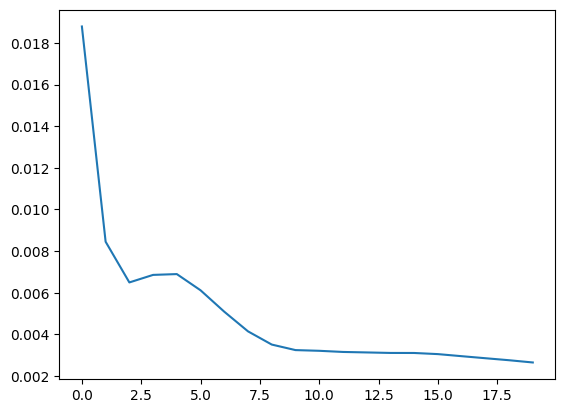

In [10]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()
history = train(model, Jets[0:10000])
plt.plot(history)